# Autoencoder

 A CCN based autoencoder.

 Steps:

 1. build an autoencoder
 2. cluster code

## Load dataset

In [947]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras_utils

In [948]:
def load_dataset():
    data = pd.read_csv("./datasets/our2/dataset_50_2.5.csv", header=None, names=range(750))
    labels = pd.read_csv("./datasets/our2/dataset_labels_50_2.5.csv", header=None, names=["user", "model", "label"])

    return data, labels

In [949]:
def print_stats(ds: pd.DataFrame):
    print("Shape", ds.shape)
    print("Columns", ds.columns)

In [950]:
X_df, y_df = load_dataset()

In [951]:
print_stats(X_df)
print_stats(y_df)

Shape (22589, 750)
Columns Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            740, 741, 742, 743, 744, 745, 746, 747, 748, 749],
           dtype='int64', length=750)
Shape (22589, 3)
Columns Index(['user', 'model', 'label'], dtype='object')


## Data Exploration


In [952]:
print(X_df.columns)
print(y_df.columns)

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            740, 741, 742, 743, 744, 745, 746, 747, 748, 749],
           dtype='int64', length=750)
Index(['user', 'model', 'label'], dtype='object')


In [953]:
print("Users", y_df["user"].unique())
print("Models", y_df["model"].unique())
print("Classes", y_df["label"].unique())

Users ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i']
Models ['nexus4_1' 'nexus4_2' 's3_1' 's3_2' 's3mini_1' 's3mini_2']
Classes ['stand' 'sit' 'walk' 'stairsup' 'stairsdown' 'bike']


## Preprocessing

In [954]:
def get_label(x):
    return x[2]

In [955]:
def restructure(x):
    return x.reshape(-1, 6, 125)

In [956]:
def plot_acc(x):
    plt.plot(x[0])
    plt.plot(x[1])
    plt.plot(x[2])

def plot_gyro(x):
    plt.plot(x[3])
    plt.plot(x[4])
    plt.plot(x[5])

def plot_sensors(x):
    plt.subplot(1, 2, 1)
    plot_acc(x)
    plt.subplot(1, 2, 2)
    plot_gyro(x)

In [957]:
def normalize(x):
    min_val = np.max(x)
    max_val = np.min(x)
    
    x = (x - min_val) / (max_val - min_val)
    
    return x

In [958]:
from sklearn import model_selection # import train_test_split

def train_test_split(x):
    return model_selection.train_test_split(x, test_size=0.3, random_state=42)

Preoprocess the dataset with the following steps:

1. From the dataset to numpy arrays
2. Restructure plain data vector from (750,) to (6,125) where first 3 vectors are accelerometer's x, y, z components while second 3 vectors are gyroscope's x, y, z components
3. Normalize data
4. Split the dataset in train and test set
4. Disregard useless informations in y

In [959]:
but_last_user_indicies = y_df['user'] < "i"

In [960]:
# Shuffle the dataset
X_shuffled_df = X_df.sample(frac=1)
y_shuffled_df = y_df.reindex(X_shuffled_df.index)

# Split the dataset into training and test sets
X_train_df = X_shuffled_df.loc[but_last_user_indicies]
X_test_df = X_shuffled_df.loc[~but_last_user_indicies]

y_train_df = y_shuffled_df.loc[but_last_user_indicies]
y_test_df = y_shuffled_df.loc[~but_last_user_indicies]

print("X_train_df =", len(X_train_df))
print("X_test_df =", len(X_test_df))
print("y_train_df =", len(y_train_df))
print("y_test_df =", len(y_test_df))

assert len(X_train_df) == len(y_train_df), "X train and y train do not contain same number of samples"
assert len(X_test_df) == len(y_test_df), "X test and y test do not contain same number of samples"

X_train_df = 19903
X_test_df = 2686
y_train_df = 19903
y_test_df = 2686


In [961]:
# 1. Back to numpy
X_train = X_train_df.loc[:].to_numpy()
y_train = y_train_df.loc[:].to_numpy()
y_train_hot = pd.get_dummies(y_train_df['label']).to_numpy()
X_test = X_test_df.loc[:].to_numpy()
y_test = y_test_df.loc[:].to_numpy()
y_test_hot = pd.get_dummies(y_test_df['label']).to_numpy()

# 2. Restructure the array
X_train = restructure(X_train)
X_test = restructure(X_test)

# 3. Normalize
# NB: we do not normalize beacause the distance between points and reconstructed points
# is reduced but the signal is not well represented
#X_train = normalize(X_train)
#X_test = normalize(X_test)

# 5. Keep only label
y_train = np.array(list(map(get_label, y_train)))
y_test = np.array(list(map(get_label, y_test)))

In [962]:
print(X_train.shape)
print(y_train.shape)

(19903, 6, 125)
(19903,)


In [963]:
assert X_train.shape == (y_train.shape[0], 6, 125), f"Invalid shape of X_train: {X_train.shape}"
assert y_train.shape == (X_train.shape[0],), f"Invalid shape of y_train: {y_train.shape}"
assert X_test.shape == (y_test.shape[0], 6, 125), f"Invalid shape of X_test: {X_test.shape}"
assert y_test.shape == (X_test.shape[0],), f"Invalid shape of y_test: {y_test.shape}"
assert y_train_hot.shape == (y_train.shape[0],6), f"Invalid shape of y_train_hot: {y_train_hot.shape}"
assert y_test_hot.shape == (y_test.shape[0],6), f"Invalid shape of y_test_hot: {y_test_hot.shape}"

Labels

In [964]:
classes = np.unique(y_train)
num_classes = len(np.unique(y_train))

print(f"Classes {classes}")
print(f"Num classes {num_classes}")

Classes ['bike' 'sit' 'stairsdown' 'stairsup' 'stand' 'walk']
Num classes 6


Plot some samples

X_train[2894]: stand


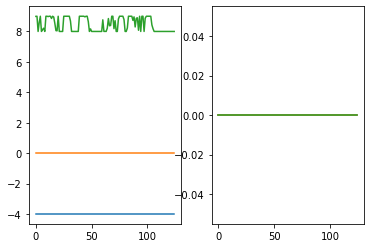

X_train[1223]: walk


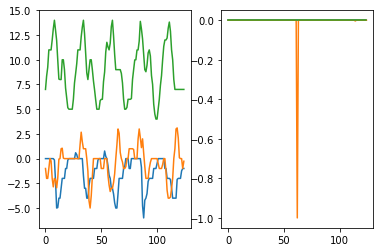

X_train[15418]: sit


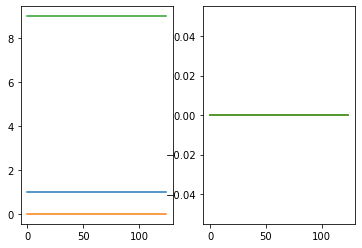

X_train[2275]: stairsup


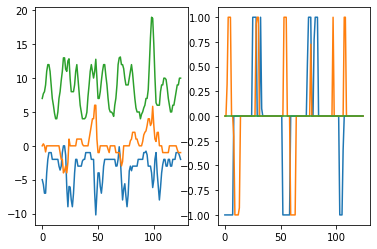

X_train[7388]: walk


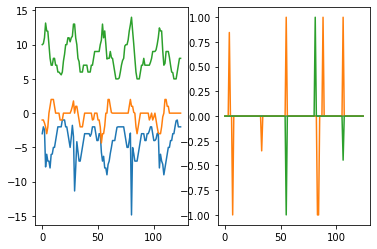

X_train[627]: stand


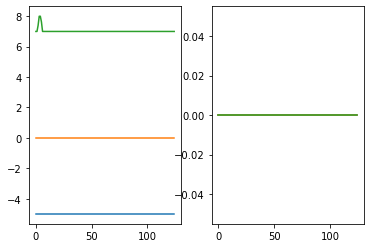

X_train[10163]: bike


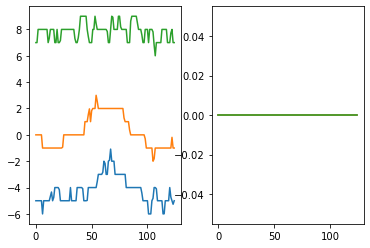

X_train[19553]: walk


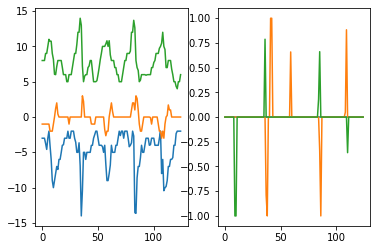

X_train[13429]: bike


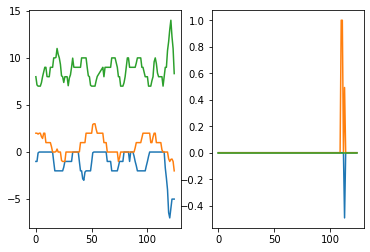

X_train[6614]: stairsup


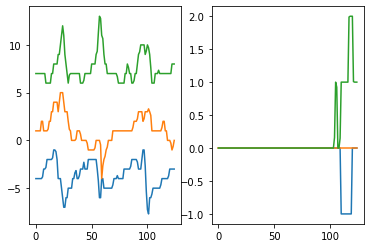

In [965]:
import random

for _ in range(10):
    i = random.randint(0, X_train.shape[0]) 
    x = X_train[i]

    print(f"X_train[{i}]: {y_train[i]}")
    plot_sensors(x)
    plt.show()

## Helpers

In [966]:
def get_name(i):
    assert i >= 0 and i <= 5, f"Component {i} is not supported, must be between 0 and 5"
    names = ["x_acc", "y_acc", "z_acc", "x_gyro", "y_gyro", "z_gyro"]

    return names[i]

def plot_reconstruction_error(sample, reconstruction):

    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.title(get_name(i))

        plt.plot(sample[i],'b')
        plt.plot(reconstruction[i], 'r')
        plt.fill_between(np.arange(125), reconstruction[i], sample[i], color='lightcoral' )

    plt.legend(labels=["sample", "reconstruction", "error"])


def visualize(sample, code, reconstruction):
    plt.subplot(1, 5, 1)
    plt.title("acc original")
    plot_acc(sample)

    plt.subplot(1, 5, 2)
    plt.title("gyro original")
    plot_gyro(sample)

    plt.subplot(1, 5, 3)
    plt.title("code")
    plt.imshow(code)

    plt.subplot(1, 5, 4)
    plt.title("acc reconstructed")
    plot_acc(reconstruction)

    plt.subplot(1, 5, 5)
    plt.title("gyro reconstructed")
    plot_gyro(reconstruction)


In [967]:
def plot_loss(history):
    h = history.history
    plt.plot(h["loss"], label="loss")
    plt.plot(h["val_loss"], label="val_loss")
    plt.legend()
    plt.show()

## Model (2)

X_train[0]: bike


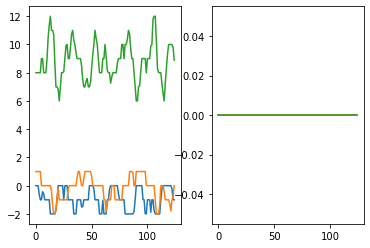

X_train[1]: sit


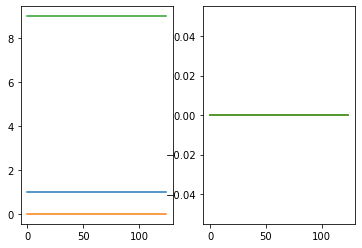

X_train[2]: stairsdown


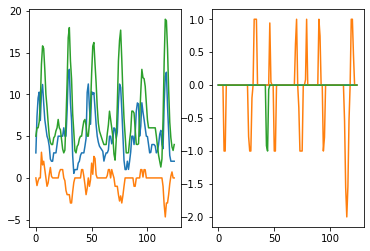

X_train[3]: stairsup


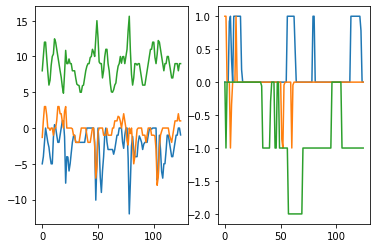

X_train[4]: walk


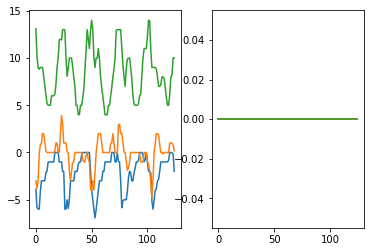

X_train[5]: bike


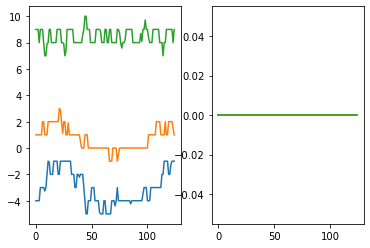

X_train[6]: bike


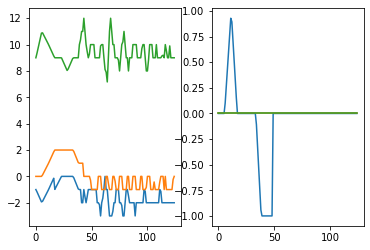

X_train[7]: walk


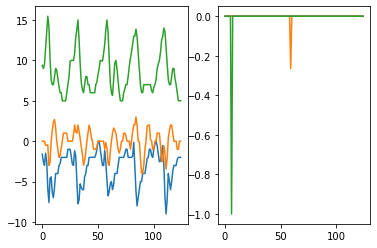

X_train[8]: stairsup


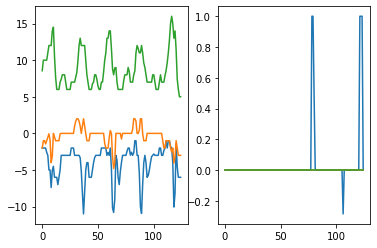

X_train[9]: stairsup


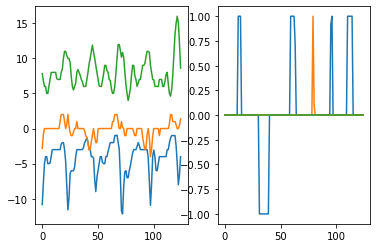

In [968]:
import random

for i in range(10):
    #i = random.randint(0, X_train.shape[0]) 
    x = X_train[i]

    print(f"X_train[{i}]: {y_train[i]}")
    plot_sensors(x)
    plt.show()

In [1016]:
DATA_SHAPE = X_train.shape[1:]
CODE_SIZE = 48

assert CODE_SIZE % 6 == 0, f"Invalid code size: {CODE_SIZE} is not multiple of 6"

In [1017]:
def build_encoder(data_shape, code_size):
    inputs = tf.keras.Input(data_shape)
    X = layers.Flatten()(inputs)
    outputs = layers.Dense(code_size, activation="sigmoid")(X)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [1018]:

def build_decoder(data_shape, code_size):
    inputs = tf.keras.Input((code_size,))
    X = layers.Dense(np.prod(data_shape), activation=None)(inputs)
    outputs = layers.Reshape(data_shape)(X)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [1019]:
encoder = build_encoder(DATA_SHAPE, CODE_SIZE)
decoder = build_decoder(DATA_SHAPE, CODE_SIZE)

In [1020]:
encoder.summary()

Model: "functional_465"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_247 (InputLayer)       [(None, 6, 125)]          0         
_________________________________________________________________
flatten_113 (Flatten)        (None, 750)               0         
_________________________________________________________________
dense_313 (Dense)            (None, 48)                36048     
Total params: 36,048
Trainable params: 36,048
Non-trainable params: 0
_________________________________________________________________


In [1021]:
decoder.summary()

Model: "functional_467"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_248 (InputLayer)       [(None, 48)]              0         
_________________________________________________________________
dense_314 (Dense)            (None, 750)               36750     
_________________________________________________________________
reshape_125 (Reshape)        (None, 6, 125)            0         
Total params: 36,750
Trainable params: 36,750
Non-trainable params: 0
_________________________________________________________________


In [1022]:
def build_autoencoder(encoder, decoder):
    inputs = tf.keras.Input(DATA_SHAPE)  # input
    codes = encoder(inputs)              # build the code with the encoder
    outputs = decoder(codes)             # reconstruction the signal with the decoder

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [1023]:
autoencoder = build_autoencoder(encoder, decoder)

optimizer = "adam"
loss = "mse"

model_filename = 'autoencoder_network.hdf5'
last_finished_epoch = None
epochs=15
batch_size=128

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
save_model_checkpoint_callback = keras_utils.ModelSaveCallback(model_filename)

callbacks = [save_model_checkpoint_callback, early_stopping_callback]

autoencoder.compile(optimizer=optimizer, loss=loss)

history = autoencoder.fit(
    x=X_train, y=X_train, 
    epochs=epochs, 
    validation_data=(X_test, X_test), 
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1, 
    initial_epoch=last_finished_epoch or 0)

Epoch 1/15
156/156 [==============================] - 1s 3ms/step - loss: 8.0269 - val_loss: 3.5152
Epoch 2/15
156/156 [==============================] - 0s 3ms/step - loss: 2.7113 - val_loss: 1.5636
Epoch 3/15
156/156 [==============================] - 0s 2ms/step - loss: 1.8803 - val_loss: 1.0717
Epoch 4/15
156/156 [==============================] - 0s 2ms/step - loss: 1.5931 - val_loss: 0.8875
Epoch 5/15
156/156 [==============================] - 0s 2ms/step - loss: 1.4748 - val_loss: 0.8265
Epoch 6/15
156/156 [==============================] - 0s 3ms/step - loss: 1.4113 - val_loss: 0.7939
Epoch 7/15
156/156 [==============================] - 0s 3ms/step - loss: 1.3623 - val_loss: 0.7768
Epoch 8/15
156/156 [==============================] - 0s 2ms/step - loss: 1.3274 - val_loss: 0.7615
Epoch 9/15
156/156 [==============================] - 0s 2ms/step - loss: 1.2985 - val_loss: 0.7571
Epoch 10/15
156/156 [==============================] - 0s 3ms/step - loss: 1.2717 - val_loss: 0.7478

In [1024]:
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [1025]:
h = history.history

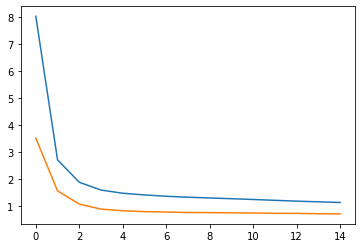

In [1026]:
plt.plot(h['loss'], label="loss")
plt.plot(h['val_loss'], label="val_loss")
plt.show()

In [1027]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)

Convolutional autoencoder MSE: 0.7088601589202881


PCA MSE: 0.7088601589202881


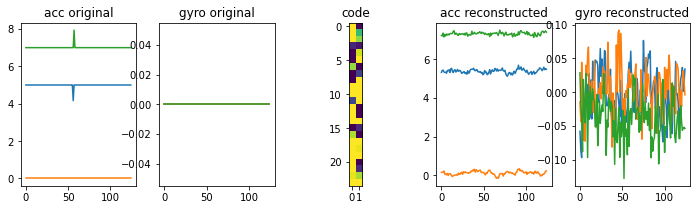

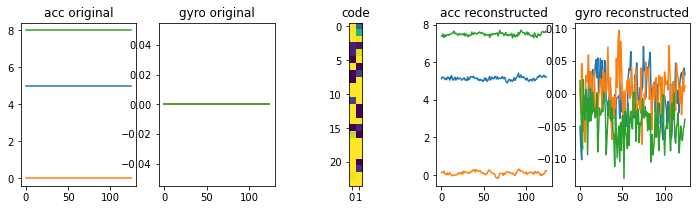

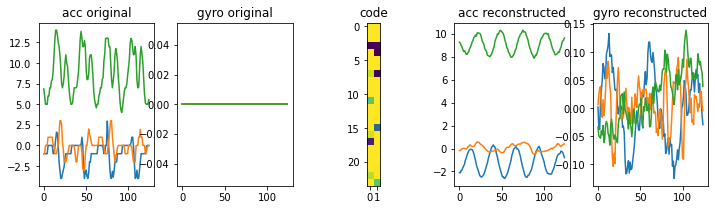

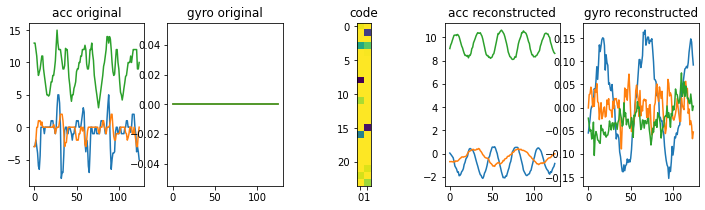

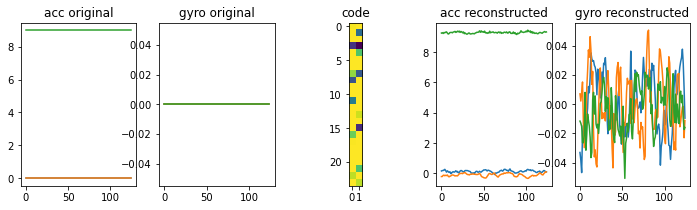

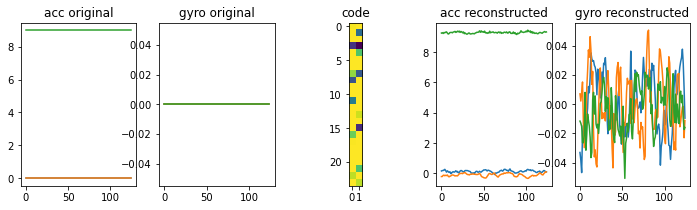

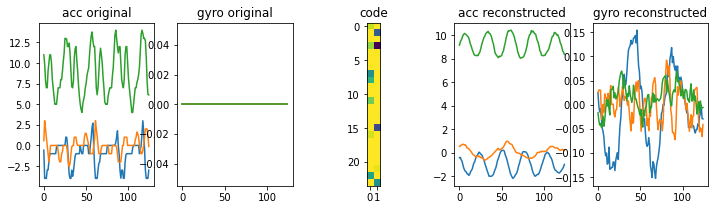

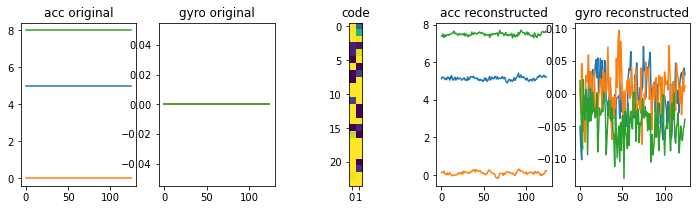

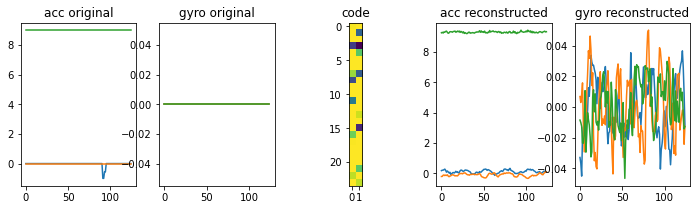

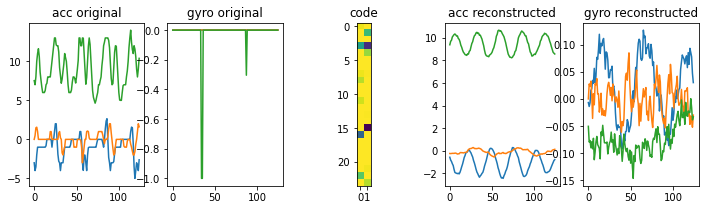

In [1028]:
loss = autoencoder.evaluate(X_test, X_test, verbose=0)
print("PCA MSE:", loss)

for i in range(10):
    sample = X_test[i]
    code = encoder.predict(sample[np.newaxis, :])[0]
    reconstruction = decoder.predict(code[np.newaxis, :])[0]
    
    plt.figure(figsize=(12,3))
    visualize(sample=sample, code=code.reshape(CODE_SIZE // 2, 2), reconstruction=reconstruction)
    plt.show()

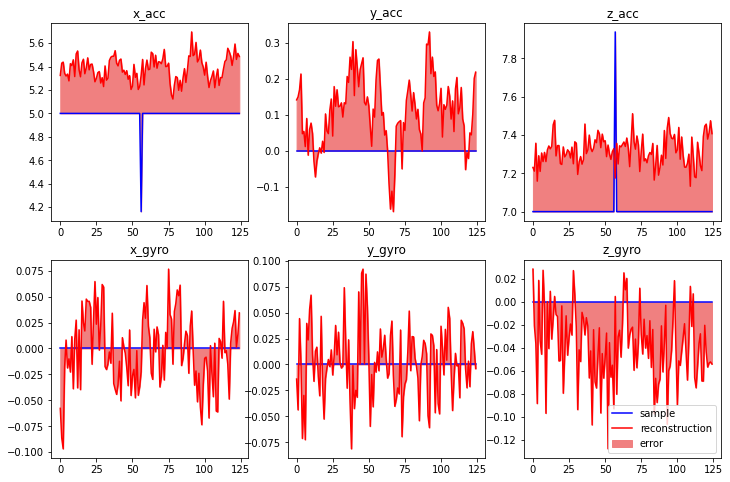

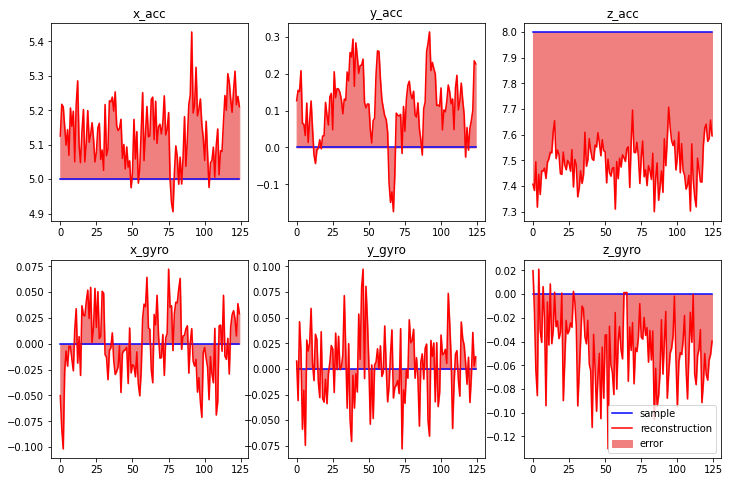

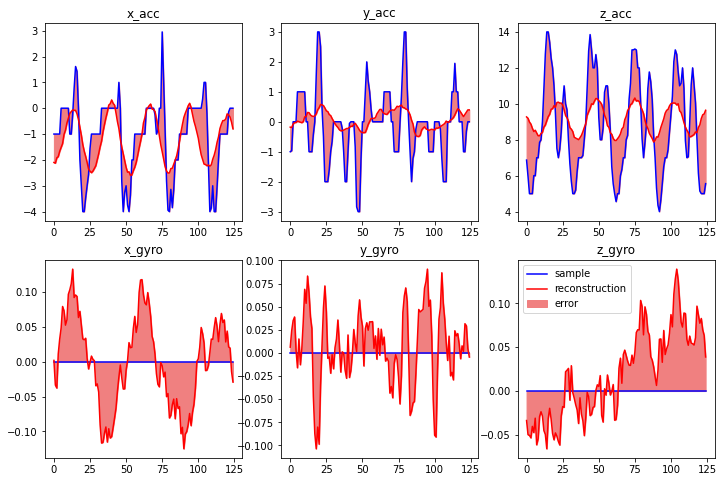

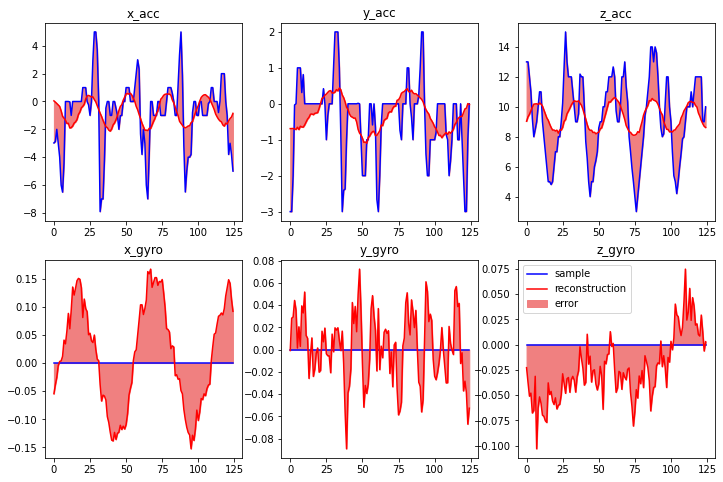

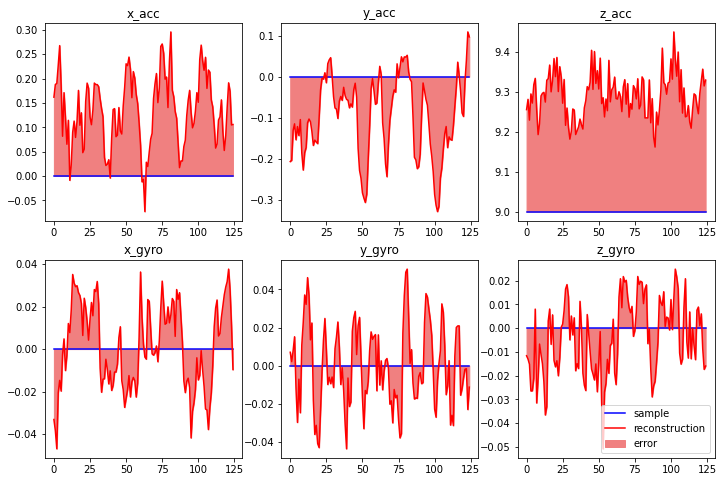

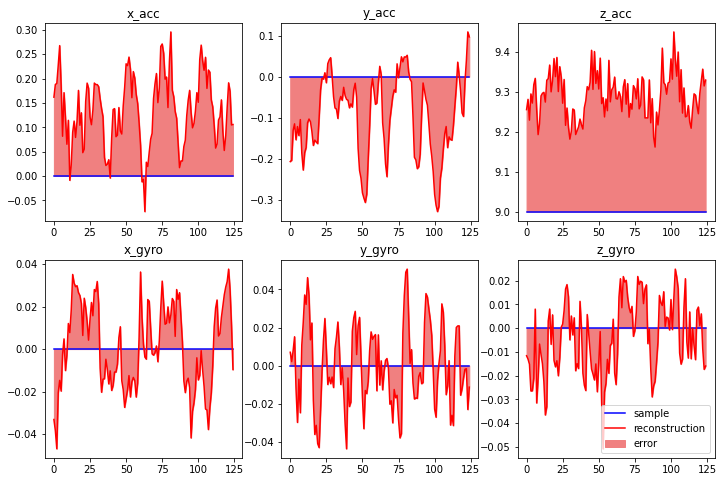

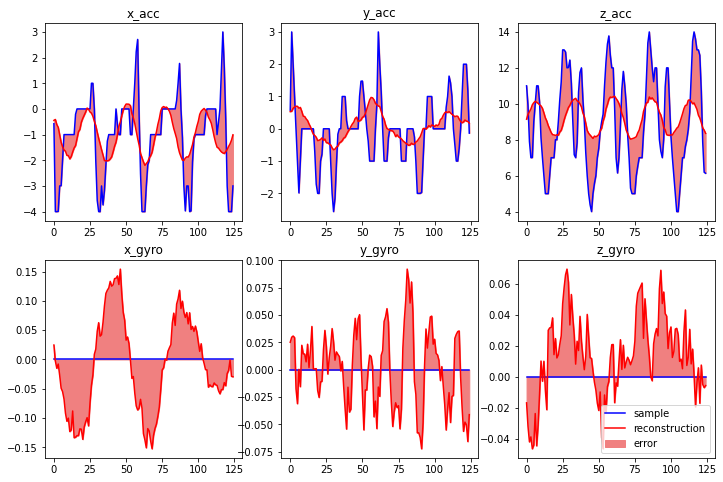

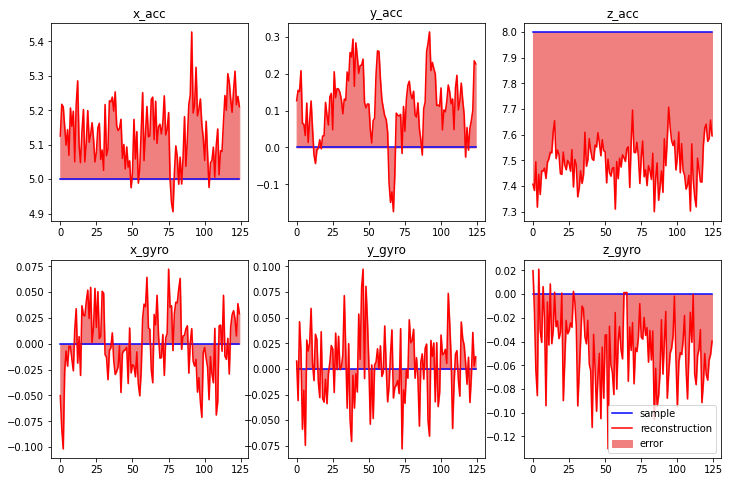

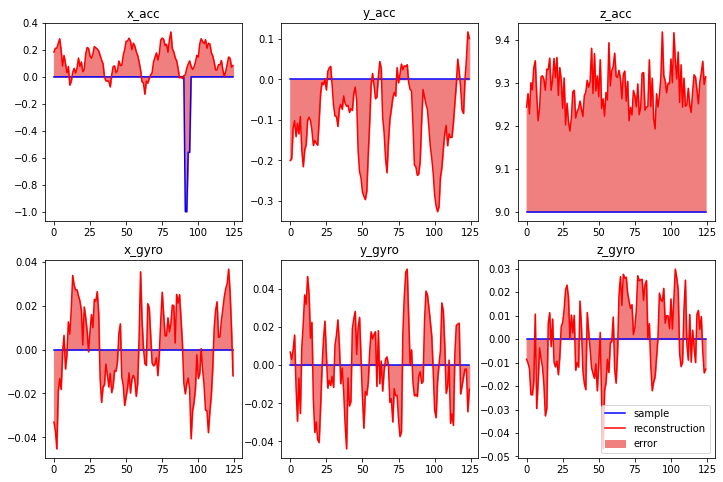

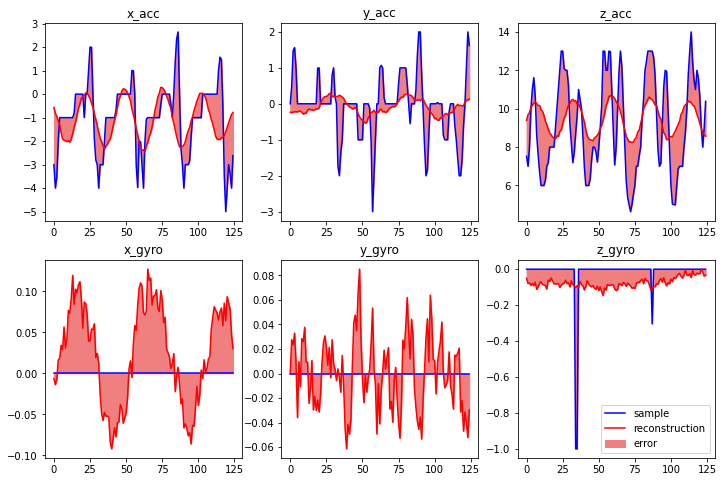

In [1029]:
samples = X_test[:10]
codes = encoder.predict(samples)
reconstructions = decoder.predict(codes)

for i in range(10):
    sample = samples[i]
    reconstruction = reconstructions[i]

    plt.figure(figsize=(12,8))
    plot_reconstruction_error(sample, reconstruction)
    plt.show()

## Model (3)

In [1031]:
X_train_acc = np.array(list(map(lambda x: x[:3], X_train)))
X_test_acc = np.array(list(map(lambda x: x[:3], X_test)))

X_train_gyro = np.array(list(map(lambda x: x[3:], X_train)))
X_test_gyro = np.array(list(map(lambda x: x[3:], X_test)))

print("X_train_acc.shape =", X_train_acc.shape)
print("X_test_acc.shape =", X_test_acc.shape)
print("X_train_gyro.shape =", X_train_gyro.shape)
print("X_test_gyro.shape =", X_test_gyro.shape)

X_train_acc.shape = (19903, 3, 125)
X_test_acc.shape = (2686, 3, 125)
X_train_gyro.shape = (19903, 3, 125)
X_test_gyro.shape = (2686, 3, 125)


In [1041]:
DATA_SHAPE = X_train_acc.shape[1:]
CODE_SIZE_ACC = 36
CODE_SIZE_GYRO = 36

In [1042]:
optimizer = "adam"
loss = "mse"

model_filename = 'autoencoder_network.hdf5'
last_finished_epoch = None
epochs=15
batch_size=128

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
save_model_checkpoint_callback = keras_utils.ModelSaveCallback(model_filename)

callbacks = [save_model_checkpoint_callback, early_stopping_callback]

In [1043]:
encoder_acc = build_encoder(DATA_SHAPE, CODE_SIZE_ACC)
decoder_acc = build_decoder(DATA_SHAPE, CODE_SIZE_ACC)

autoencoder_acc = build_autoencoder(encoder_acc, decoder_acc)

autoencoder_acc.compile(optimizer=optimizer, loss=loss)

history = autoencoder_acc.fit(
    x=X_train_acc, y=X_train_acc, 
    epochs=epochs, 
    validation_data=(X_test_acc, X_test_acc), 
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1, 
    initial_epoch=last_finished_epoch or 0)

Epoch 1/15
156/156 [==============================] - 0s 3ms/step - loss: 18.2891 - val_loss: 9.0872
Epoch 2/15
156/156 [==============================] - 0s 2ms/step - loss: 6.4723 - val_loss: 3.8748
Epoch 3/15
156/156 [==============================] - 0s 2ms/step - loss: 4.0729 - val_loss: 2.4362
Epoch 4/15
156/156 [==============================] - 0s 2ms/step - loss: 3.3083 - val_loss: 1.9175
Epoch 5/15
156/156 [==============================] - 0s 2ms/step - loss: 3.0124 - val_loss: 1.7402
Epoch 6/15
156/156 [==============================] - 0s 2ms/step - loss: 2.8705 - val_loss: 1.6632
Epoch 7/15
156/156 [==============================] - 0s 2ms/step - loss: 2.7984 - val_loss: 1.6194
Epoch 8/15
156/156 [==============================] - 0s 2ms/step - loss: 2.7579 - val_loss: 1.6043
Epoch 9/15
156/156 [==============================] - 0s 2ms/step - loss: 2.7287 - val_loss: 1.6045
Epoch 10/15
156/156 [==============================] - 0s 2ms/step - loss: 2.7023 - val_loss: 1.589

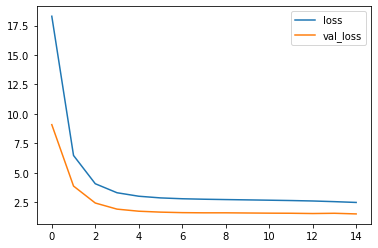

In [1044]:
plot_loss(history)

In [1045]:


encoder_gyro = build_encoder(DATA_SHAPE, CODE_SIZE_GYRO)
decoder_gyro = build_decoder(DATA_SHAPE, CODE_SIZE_GYRO)

autoencoder_gyro = build_autoencoder(encoder_gyro, decoder_gyro)

autoencoder_gyro.compile(optimizer=optimizer, loss=loss)

history = autoencoder_gyro.fit(
    x=X_train_gyro, y=X_train_gyro,
    epochs=epochs, 
    validation_data=(X_test_gyro, X_test_gyro), 
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1, 
    initial_epoch=last_finished_epoch or 0)

Epoch 1/15
156/156 [==============================] - 0s 2ms/step - loss: 0.0656 - val_loss: 0.0079
Epoch 2/15
156/156 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0061
Epoch 3/15
156/156 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0052
Epoch 4/15
156/156 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0047
Epoch 5/15
156/156 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0043
Epoch 6/15
156/156 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0040
Epoch 7/15
156/156 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0038
Epoch 8/15
156/156 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0037
Epoch 9/15
156/156 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0036
Epoch 10/15
156/156 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0035

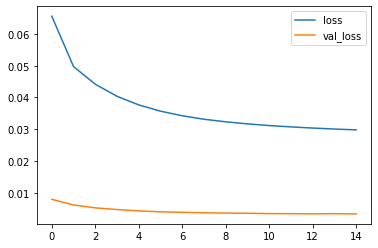

In [1046]:
plot_loss(history)

In [1047]:
loss_acc = autoencoder_acc.evaluate(X_test_acc, X_test_acc, verbose=0)
loss_gyro = autoencoder_gyro.evaluate(X_test_gyro, X_test_gyro, verbose=0)
print("MSE ACC:", loss_acc)
print("MSE GYRO:", loss_gyro)

MSE ACC: 1.5111451148986816
MSE GYRO: 0.003302863100543618


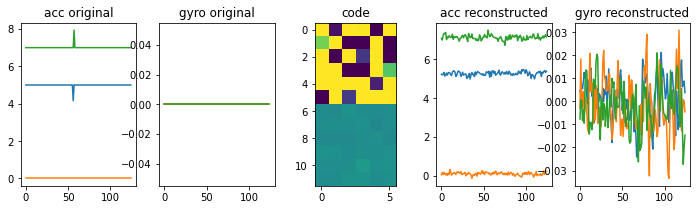

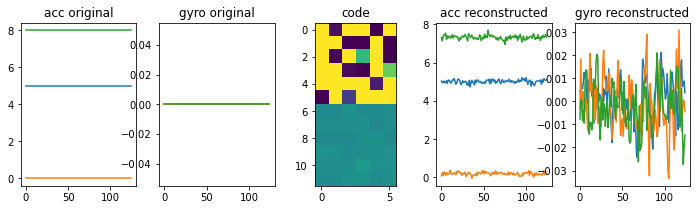

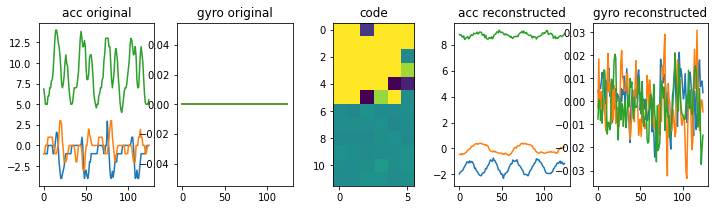

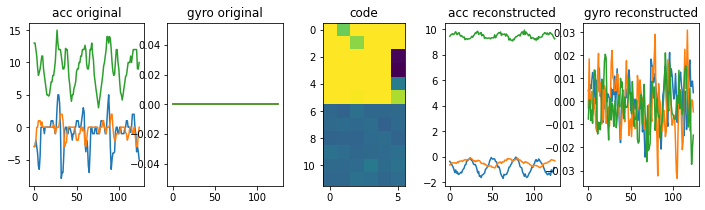

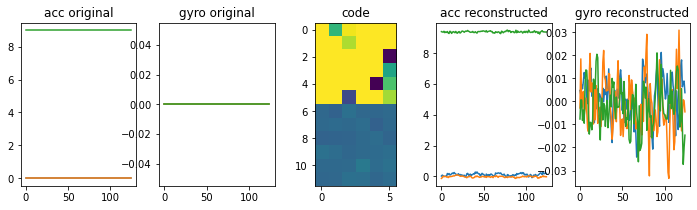

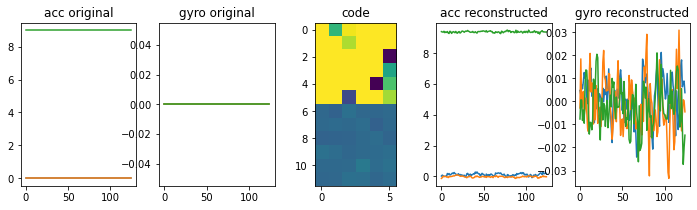

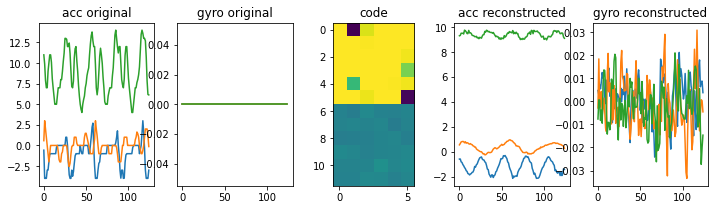

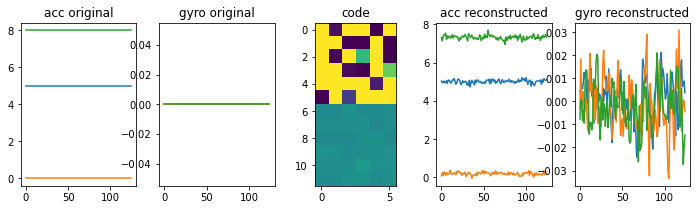

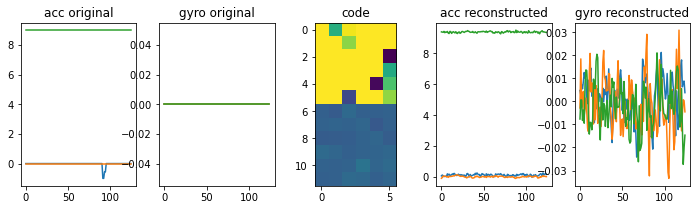

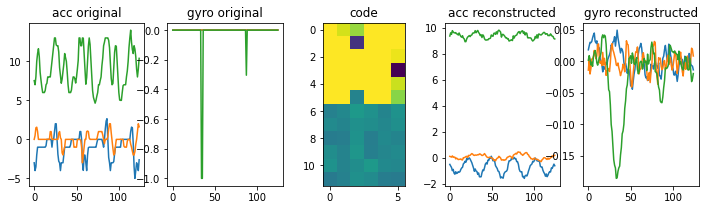

In [1048]:
for i in range(10):
    sample_acc = X_test_acc[i]
    sample_gyro = X_test_gyro[i]

    code_acc = encoder_acc.predict(sample_acc[np.newaxis, :])[0]
    code_gyro = encoder_gyro.predict(sample_gyro[np.newaxis, :])[0]

    reconstruction_acc = decoder_acc.predict(code_acc[np.newaxis, :])[0]
    reconstruction_gyro = decoder_gyro.predict(code_gyro[np.newaxis, :])[0]
    
    sample = np.append(sample_acc, sample_gyro).reshape((6,125))
    code = np.append(code_acc, code_gyro).reshape(((CODE_SIZE_ACC+CODE_SIZE_GYRO)//6,6))
    reconstruction = np.append(reconstruction_acc, reconstruction_gyro).reshape((6,125))

    plt.figure(figsize=(12,3))
    visualize(sample=sample, code=code, reconstruction=reconstruction)
    plt.show()

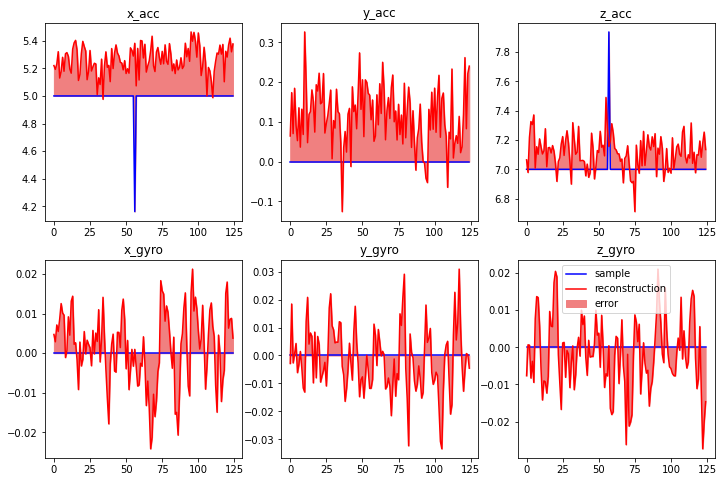

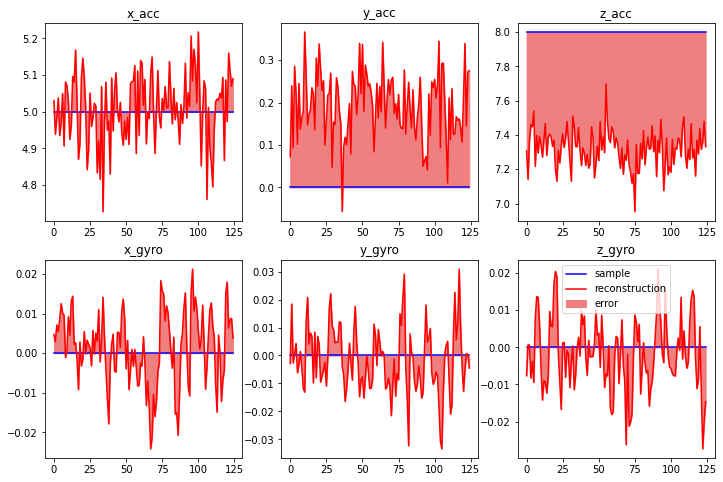

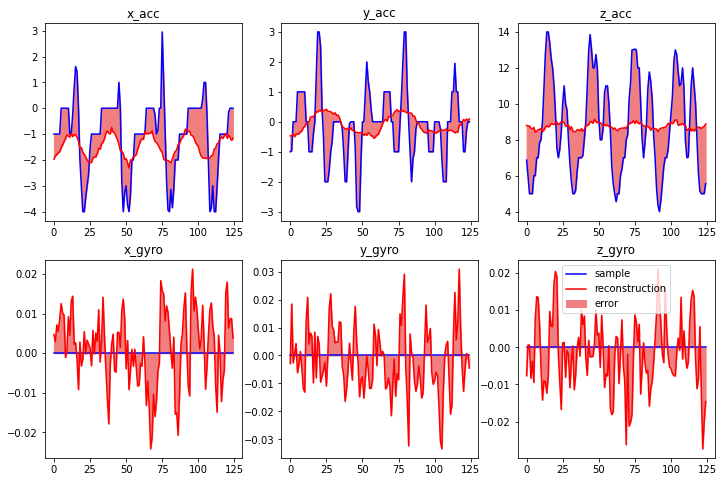

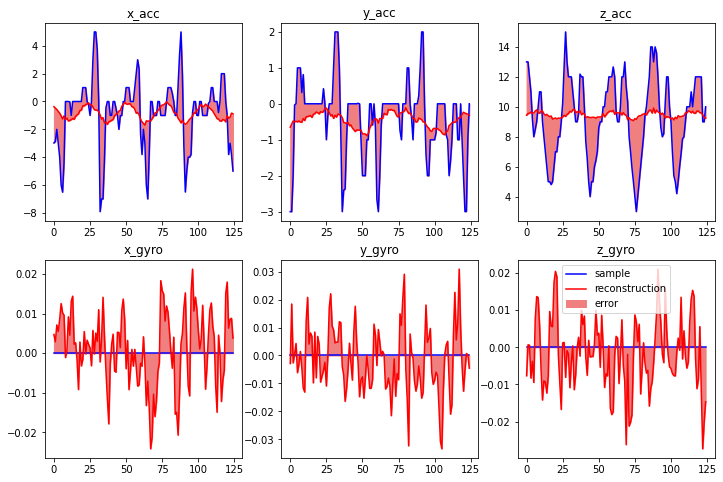

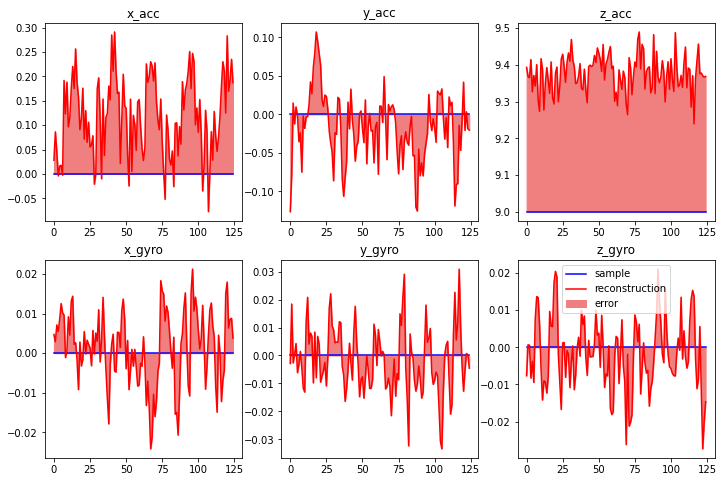

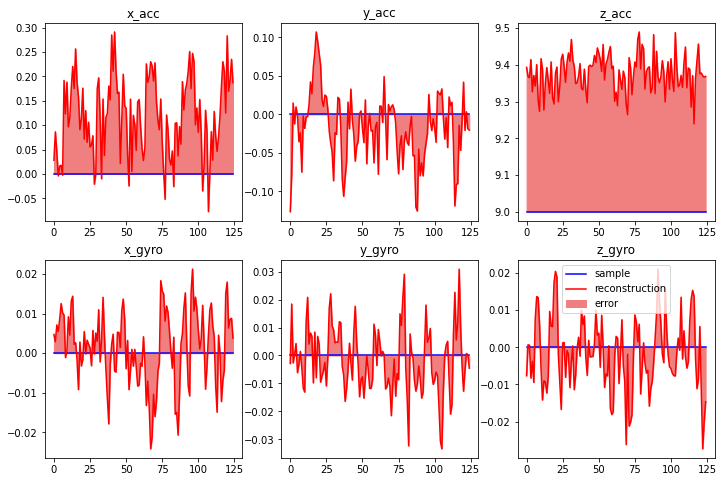

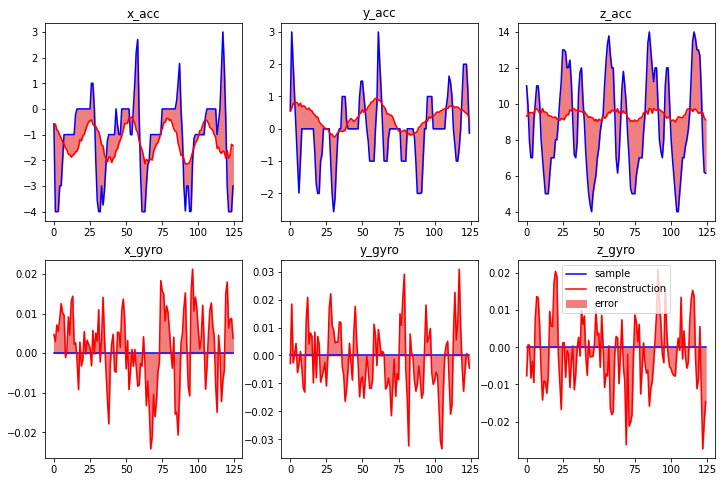

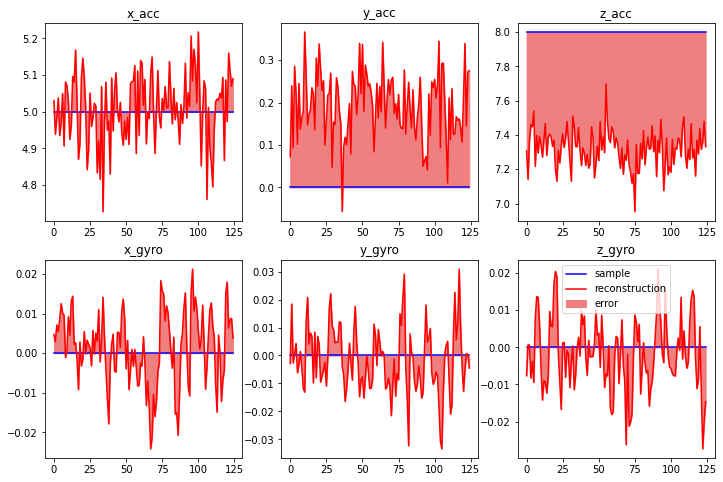

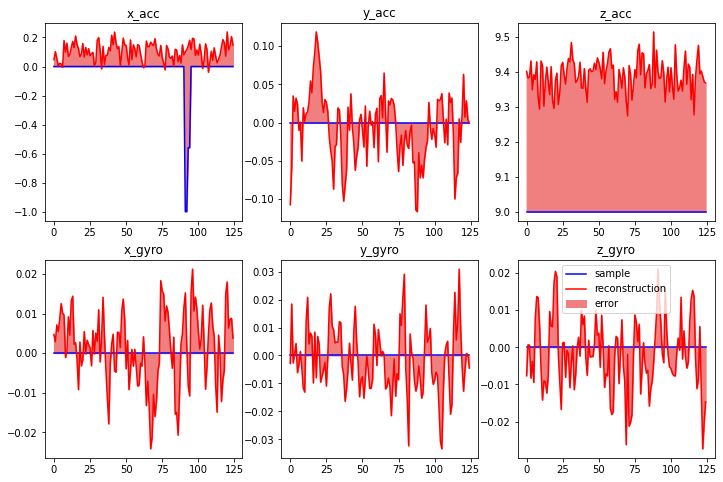

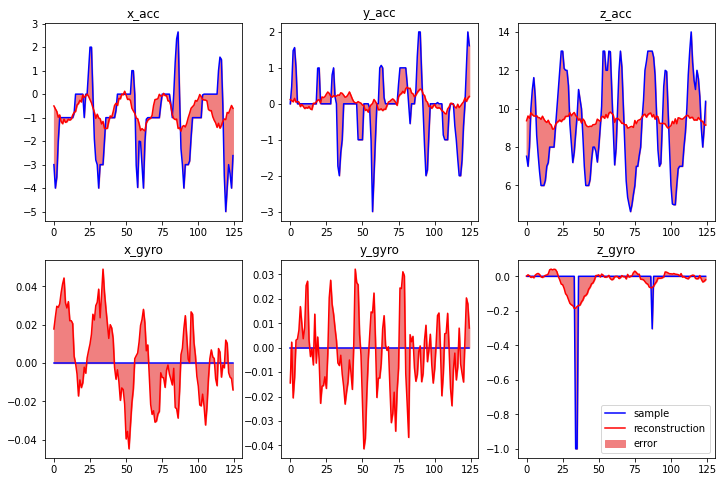

In [1049]:
for i in range(10):
    sample_acc = X_test_acc[i]
    sample_gyro = X_test_gyro[i]

    code_acc = encoder_acc.predict(sample_acc[np.newaxis, :])[0]
    code_gyro = encoder_gyro.predict(sample_gyro[np.newaxis, :])[0]

    reconstruction_acc = decoder_acc.predict(code_acc[np.newaxis, :])[0]
    reconstruction_gyro = decoder_gyro.predict(code_gyro[np.newaxis, :])[0]
    
    sample = np.append(sample_acc, sample_gyro).reshape((6,125))
    code = np.append(code_acc, code_gyro).reshape(((CODE_SIZE_ACC+CODE_SIZE_GYRO)//6,6))
    reconstruction = np.append(reconstruction_acc, reconstruction_gyro).reshape((6,125))

    plt.figure(figsize=(12,8))
    plot_reconstruction_error(sample, reconstruction)
    plt.show()